In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import sys
sys.path.append("..")
from RunningScripts.read_wandb import wandb_results
api = wandb_results("206713612", wandb_username="maayan-aytek1")

BASE_METRIC = "accuracy_per_mean_user_and_bot"

In [4]:
import os
current_dir = os.path.dirname(os.path.abspath('__file__'))
csv_dir_path = os.path.join(os.path.dirname(current_dir), 'RunningScripts')

In [17]:
def result_metric(sweeps, group_name, drop_list=[0], drop_HPT=False, metric=BASE_METRIC, epoch="best", dummy_group=False, model=False):
    df = api.get_sweeps_results(sweeps, metric=metric, dir_path=csv_dir_path) 
    config_cols = [c for c in df.columns if "config_" in c and c!="config_wandb_run_id" and c!="config_online_simulation_size"]
    HPT_cols = [col for col in config_cols if df[col].nunique() > 1]
    if drop_HPT:
        df=df.drop([c for c in HPT_cols if not c in ["config_LLM_SIM_SIZE", "config_seed"]], axis=1)
        HPT_cols = ["config_LLM_SIM_SIZE", "config_seed"]  
    numeric_cols = df.select_dtypes(include='number').columns.tolist()
    if model: 
        df = df.dropna(subset='config_rt_model_file_name')
        df['config_rt_model_file_name'] = df['config_rt_model_file_name'].apply(lambda x: x.split('_seed')[0])
    if not dummy_group:
        grouped = df.groupby([c for c in HPT_cols if c != "config_seed"])
    else:
        df['dummy_group'] = 'New LLM'
        
        grouped = df.groupby('dummy_group')
    
    mean_df = grouped[numeric_cols].mean()
    std_df = grouped[numeric_cols].std()
    
    if epoch=="best":
        best_col = mean_df[[c for c in mean_df.columns if (metric in c and metric[-4:] == c.split("_epoch")[0][-4:])]].idxmax(axis=1)
    else:
        best_col = mean_df[[c for c in mean_df.columns if f"{metric}_epoch{epoch}" in c]].idxmax(axis=1)
    
    result = grouped.apply(lambda x: x[best_col.loc[x.name]].values)
    means = grouped.apply(lambda x: x[best_col.loc[x.name]].mean())
    stds = grouped.apply(lambda x: x[best_col.loc[x.name]].std())
    
    df_cols = {'mean': means, 'std': stds, 'values': result.values}
    
    if epoch == "best":
        df_cols['epoch'] = best_col.apply(lambda x: int(x.split("epoch")[1]) if "epoch" in x else "last")
    
    df_cols['CI'] = result.apply(lambda x: bootstrap_ci(x))
    summary_df = pd.DataFrame(df_cols, index=best_col.index)
    
    for d in drop_list:
        if d in summary_df.index:
            summary_df=summary_df.drop(d)

    if len(summary_df.index.names) == 1:
        return summary_df.rename_axis(group_name)
    else:
        return summary_df

def bootstrap_ci(data, n_bootstrap=1000, ci=0.95):
    bootstrapped_means = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        bootstrapped_means.append(np.mean(sample))
    lower_bound = np.percentile(bootstrapped_means, (1 - ci) / 2 * 100)
    upper_bound = np.percentile(bootstrapped_means, (1 + ci) / 2 * 100)
    return lower_bound, upper_bound


# For HyperParameterTuning

For every configuration that you test in the sweep, you will receive in the table the average, standard deviation, all the values obtained for the different seed values, and also the confidence interval within which the result is located at a confidence level of 95%.

When epoch="best" is defined, you can check in which epoch the best result is obtained. If epoch=5 is defined, you will receive the result obtained for epoch number 5.

You can test multiple sweeps simultaneously by entering them into the list found in the first element of the function result_metric.

### Baseline

In [5]:
sweep_results = result_metric(["nh9eyaq1"], "LLMs", drop_HPT=False, epoch='best', dummy_group=True)
sweep_results

Total number of sweeps: 1
Download sweep_id='nh9eyaq1' data...


,mean,std,values,epoch,CI
LLMs,,,,,
New LLM,0.83619,0.001682,"[0.8371521808705251, 0.834866139441589, 0.8339...",14,"(0.8347650996240153, 0.8374115543134145)"


### Random

In [6]:
sweep_results = result_metric(["gihrejb0"], "LLMs", drop_HPT=False, epoch='best')
sweep_results

Total number of sweeps: 1
Download sweep_id='gihrejb0' data...


,mean,std,values,epoch,CI
LLMs,,,,,
normal,0.839446,0.002792,"[0.8417926790544936, 0.841346422342924, 0.8374...",22,"(0.8371611533684691, 0.841513371848769)"
uniform,0.838915,0.001628,"[0.8413149271737511, 0.8377004597636084, 0.839...",16,"(0.8377142146690236, 0.8402655680139134)"


### Models

In [17]:
sweep_results = result_metric(["42wibgw1"], "LLMs", drop_HPT=False, epoch='best', dummy_group=False, model=True)
sweep_results

Total number of sweeps: 1
Download sweep_id='42wibgw1' data...


,,,,mean,std,values,epoch,CI
config_rt_model_file_name,config_rt_model_class_weight,config_rt_model_top_features,config_rt_model_min_samples_leaf,,,,,
min_samples_leaf_100_class_weight_balanced_subsample_top_features_20,balanced_subsample,20,100,0.836768,0.001404,"[0.8351968767317809, 0.8379012449859079, 0.837...",21,"(0.8351968767317809, 0.8379012449859079)"
min_samples_leaf_100_class_weight_balanced_subsample_top_features_all,balanced_subsample,all,100,0.836900,0.000252,"[0.8371155752297419, 0.8366225382946252, 0.836...",9,"(0.8366225382946252, 0.8371155752297419)"
min_samples_leaf_100_class_weight_balanced_top_features_20,balanced,20,100,0.837315,0.001356,"[0.8385974426912752, 0.8374519736681949, 0.835...",18,"(0.8358950308736369, 0.8385974426912752)"
min_samples_leaf_100_class_weight_balanced_top_features_all,balanced,all,100,0.837462,0.002099,"[0.8398647309850867, 0.835986445817165, 0.8365...",18,"(0.835986445817165, 0.8398647309850867)"
min_samples_leaf_20_class_weight_balanced_subsample_top_features_20,balanced_subsample,20,20,0.836669,0.001892,"[0.8379861002281137, 0.834501391657148, 0.8375...",12,"(0.834501391657148, 0.8379861002281137)"
min_samples_leaf_20_class_weight_balanced_subsample_top_features_all,balanced_subsample,all,20,0.837695,0.001677,"[0.8377945331370256, 0.8359706140758668, 0.839...",11,"(0.8359706140758668, 0.8393197174370671)"
min_samples_leaf_20_class_weight_balanced_top_features_20,balanced,20,20,0.836614,0.001761,"[0.8356686748178921, 0.8355273771061232, 0.838...",17,"(0.8355273771061232, 0.8386460324534374)"
min_samples_leaf_20_class_weight_balanced_top_features_all,balanced,all,20,0.836802,0.001410,"[0.8379406353880007, 0.8352242637813103, 0.837...",15,"(0.8352242637813103, 0.8379406353880007)"
min_samples_leaf_50_class_weight_balanced_subsample_top_features_20,balanced_subsample,20,50,0.837531,0.002032,"[0.8383367194971337, 0.8352194818445661, 0.839...",13,"(0.8352194818445661, 0.8390366751829358)"


In [5]:
sweep_results = result_metric(["qd6p7ajy"], "LLMs", drop_HPT=False, epoch='best', dummy_group=False, model=True)
sweep_results.sort_values(by="mean", ascending=False)

Total number of sweeps: 1
Download sweep_id='qd6p7ajy' data...


100%|██████████| 36/36 [00:00<00:00, 51.92it/s]


mean  \
config_rt_w_word_count config_rt_model_file_name                          config_rt_model_class_weight config_rt_model_top_features config_rt_model_min_samples_leaf             
350                    min_samples_leaf_100_class_weight_balanced_top_... balanced                     all                          100                               0.838941   
150                    min_samples_leaf_50_class_weight_balanced_top_f... balanced                     all                          50                                0.838373   
350                    min_samples_leaf_100_class_weight_balanced_subs... balanced_subsample           20                           100                               0.838323   
                       min_samples_leaf_100_class_weight_balanced_top_... balanced                     20                           100                               0.838270   
150                    min_samples_leaf_20_class_weight_balanced_top_f... balanced                     20                           20                                0.838258   
350                    min_samples_leaf_50_class_weight_balanced_subsa... balanced_subsample           all                          50                                0.837515   
150                    min_samples_leaf_20_class_weight_balanced_top_f... balanced                     all                          20                                0.837132   
350                    min_samples_leaf_20_class_weight_balanced_subsa... balanced_subsample           20                           20                                0.837004   
                       min_samples_leaf_100_class_weight_balanced_subs... balanced_subsample           all                          100                               0.836942   
                       min_samples_leaf_50_class_weight_balanced_top_f... balanced                     20                           50                                0.836353   
                       min_samples_leaf_50_class_weight_balanced_subsa... balanced_subsample           20                           50                                0.836253   
                       min_samples_leaf_20_class_weight_balanced_subsa... balanced_subsample           all                          20                                0.835812   

                                                                                                                                                                           std  \
config_rt_w_word_count config_rt_model_file_name                          config_rt_model_class_weight config_rt_model_top_features config_rt_model_min_samples_leaf             
350                    min_samples_leaf_100_class_weight_balanced_top_... balanced                     all                          100                               0.002968   
150                    min_samples_leaf_50_class_weight_balanced_top_f... balanced                     all                          50                                0.000796   
350                    min_samples_leaf_100_class_weight_balanced_subs... balanced_subsample           20                           100                               0.002723   
                       min_samples_leaf_100_class_weight_balanced_top_... balanced                     20                           100                               0.001466   
150                    min_samples_leaf_20_class_weight_balanced_top_f... balanced                     20                           20                                0.002689   
350                    min_samples_leaf_50_class_weight_balanced_subsa... balanced_subsample           all                          50                                0.004550   
150                    min_samples_leaf_20_class_weight_balanced_top_f... balanced                     all                          20                                0.005037   
350                    min_samples_leaf_20_class_weight_balanced_subsa... b

### Heuristic

In [30]:
sweep_results = result_metric(["rr4bf5bj"], "LLMs", drop_HPT=False, epoch='best', dummy_group=False)
sweep_results.reset_index()

Total number of sweeps: 1
Download sweep_id='rr4bf5bj' data...


,config_rt_user_noise_std,config_rt_neutral_sampling,config_rt_frustration_std_method,mean,std,values,epoch,CI
0,200,1000,+,0.836979,0.001992,"[0.8400159701451503, 0.8374672073500151, 0.834...",20,"(0.835508510753624, 0.8386065825734462)"
1,200,1000,/,0.837570,0.002598,"[0.8393964648476003, 0.8355232446906189, 0.839...",last,"(0.8354718042123036, 0.8394873807381027)"
2,200,800,+,0.837341,0.002995,"[0.8378782271688218, 0.8351722705271559, 0.840...",14,"(0.8350102656603005, 0.8396724216486516)"
3,200,800,/,0.837163,0.002275,"[0.8388582202235954, 0.8338600988903725, 0.836...",19,"(0.8353541311863246, 0.8388281644230622)"
4,200,normal,+,0.837345,0.001237,"[0.8365394680610218, 0.8384429625645824, 0.836...",12,"(0.8364254228451934, 0.8383448839529024)"
5,200,normal,/,0.837635,0.002379,"[0.839637143670511, 0.8401320919190824, 0.8344...",11,"(0.8357560426088992, 0.8394628844213561)"
6,300,1000,+,0.838036,0.002364,"[0.8414243308476722, 0.839321243925161, 0.8364...",14,"(0.8363162179299343, 0.839851659987934)"
7,300,1000,/,0.836368,0.000789,"[0.8366641666218375, 0.8354961955228851, 0.837...",14,"(0.8357412774935529, 0.8369838304369315)"
8,300,800,+,0.837205,0.001097,"[0.8390263045485709, 0.8369912642463646, 0.837...",18,"(0.8365180792493341, 0.8381647341407689)"
9,300,800,/,0.836295,0.001916,"[0.8346060943480512, 0.8390550693024155, 0.834...",8,"(0.8348687521753421, 0.8378505506671526)"


In [4]:
sweep_results = result_metric(["1f6wyb4r"], "LLMs", drop_HPT=False, epoch='best')
sweep_results.reset_index()

Total number of sweeps: 1
Download sweep_id='1f6wyb4r' data...


100%|██████████| 120/120 [00:03<00:00, 35.23it/s]


,config_rt_w_word_count,config_rt_user_noise_std,config_rt_neutral_sampling,config_rt_frustration_std_method,mean,std,values,epoch,CI
0,100,300,800,+,0.836098,0.003945,"[0.8312215119669927, 0.8387861448970098, 0.839...",10,"(0.8329816757196836, 0.8389651217566325)"
1,100,300,800,/,0.836380,0.001314,"[0.8372142463384018, 0.8356490051098989, 0.837...",19,"(0.8354430622667696, 0.8373174358740698)"
2,100,300,normal,+,0.837853,0.002778,"[0.8412844941562723, 0.8363074071569248, 0.839...",9,"(0.8354709377486553, 0.8398306125506327)"
3,100,300,normal,/,0.836647,0.001719,"[0.8366933024055729, 0.8344399394704348, 0.838...",11,"(0.8353416328545687, 0.8379522165715176)"
4,100,500,800,+,0.837195,0.001534,"[0.8367860290486224, 0.8371434476197307, 0.836...",9,"(0.8361072775734435, 0.8385493728903652)"
5,100,500,800,/,0.837437,0.003066,"[0.8325561099346298, 0.8381951834093676, 0.840...",11,"(0.834811739324525, 0.8396005129647532)"
6,100,500,normal,+,0.838568,0.001077,"[0.8390195174183207, 0.8379832168384272, 0.838...",11,"(0.8377919003473663, 0.839489545377449)"
7,100,500,normal,/,0.835588,0.002369,"[0.8356821543653872, 0.836603676611369, 0.8389...",23,"(0.8336582834949802, 0.8373451393952781)"
8,125,300,800,+,0.836645,0.001882,"[0.8373728202163232, 0.83714393461135, 0.83890...",13,"(0.8351695355162859, 0.8379624993666083)"
9,125,300,800,/,0.837751,0.001996,"[0.8401258893876667, 0.8390106170314376, 0.837...",15,"(0.8361468610101264, 0.8392472356218615)"


### RT Representation

In [8]:
sweep_results = result_metric(["0381z4nx"], "LLMs", drop_HPT=False, epoch='best')
sweep_results.reset_index().sort_values(by="mean", ascending=False)

Total number of sweeps: 1
Download sweep_id='0381z4nx' data...


,config_input_dim,config_rt_baseline_std,config_rt_w_word_count,config_rt_bins_option_num,config_rt_bins_columns_rep,mean,std,values,epoch,CI
23,60,1000,150,0,one-hot,0.838727,0.002408,"[0.8401788520016553, 0.8359475008356176, 0.840...",9,"(0.8359475008356178, 0.8401788520016553)"
21,60,500,150,0,one-hot,0.837627,0.003131,"[0.8427695550000989, 0.8351287317714683, 0.838...",23,"(0.8355452246649134, 0.840132250793418)"
24,61,0,125,0,both,0.837449,0.001944,"[0.8369105586724874, 0.837977145485305, 0.8366...",16,"(0.8360668818237172, 0.838988170713597)"
18,60,0,125,0,one-hot,0.837213,0.001145,"[0.8354284579898273, 0.8374474727140917, 0.836...",19,"(0.8362123923814927, 0.8380022112023257)"
29,61,500,150,0,both,0.837199,NaN,[0.8371991778935945],18,"(0.8371991778935945, 0.8371991778935945)"
20,60,500,125,0,one-hot,0.836566,0.001246,"[0.8372656524214185, 0.8371542080645357, 0.834...",14,"(0.8354524267629257, 0.8374449240946275)"
22,60,1000,125,0,one-hot,0.836386,0.001402,"[0.8356741829489508, 0.8378905578479436, 0.834...",9,"(0.8353182841585184, 0.837418934313877)"
19,60,0,150,0,one-hot,0.836226,0.001397,"[0.8373215859800484, 0.8368107487126704, 0.837...",16,"(0.8349580456250674, 0.8371347553558177)"
26,61,0,150,0,both,0.835995,0.001153,"[0.8355904069039789, 0.8347365093242435, 0.835...",12,"(0.8352001161312355, 0.8369576913251061)"
39,66,0,150,2,one-hot,0.834203,0.002501,"[0.8360296390623763, 0.8361267490553906, 0.835...",21,"(0.8320148391466903, 0.8358816433211171)"


In [7]:
sweep_results = result_metric(["elct280c"], "LLMs", drop_HPT=False, epoch='best')
sweep_results.reset_index().sort_values(by="mean", ascending=False)

Total number of sweeps: 1
Download sweep_id='elct280c' data...


,config_input_dim,config_rt_bins_option_num,config_rt_bins_columns_rep,config_rt_sampling_distribution,mean,std,values,epoch,CI
9,61,0,both,uniform,0.838557,0.001784,"[0.8368175755631474, 0.8398682831300783, 0.839...",14,"(0.8371920075894519, 0.8398947565479998)"
6,60,0,one-hot,normal,0.838114,0.002923,"[0.836975102149344, 0.838302228748287, 0.83957...",15,"(0.835943930915079, 0.8403721105050064)"
8,61,0,both,normal,0.836233,0.001865,"[0.833503279110266, 0.8350806726318529, 0.8377...",12,"(0.8345815728580366, 0.837568655149625)"
7,60,0,one-hot,uniform,0.835636,0.002291,"[0.8369918168943377, 0.8352967931654662, 0.835...",22,"(0.8338173375427494, 0.8372268119338884)"
14,66,2,one-hot,normal,0.834726,0.003391,"[0.8317206224116411, 0.8330481336548199, 0.834...",15,"(0.8324442785782505, 0.8375822655674922)"
16,67,2,both,normal,0.834366,0.004224,"[0.830253546544186, 0.8384409700502101, 0.8309...",14,"(0.8310695433889373, 0.8374973539326258)"
15,66,2,one-hot,uniform,0.833809,0.003548,"[0.8280899592640225, 0.8363338294483107, 0.837...",8,"(0.8308391250680455, 0.8361717700871886)"
17,67,2,both,uniform,0.833623,0.000956,"[0.8342407711345775, 0.833062873778419, 0.8322...",9,"(0.832894650504046, 0.8343329912634097)"
11,61,1,one-hot,uniform,0.833488,0.001617,"[0.8326290440627685, 0.8337489093870296, 0.836...",15,"(0.8323564941447105, 0.8348058258253308)"
13,62,1,both,uniform,0.833356,0.002435,"[0.8370943381833326, 0.8320616659959371, 0.832...",16,"(0.8317432265869392, 0.8354194125619883)"


### Final Results

#### Random

In [5]:
sweep_results = result_metric(["y6er7ryu"], "LLMs", drop_HPT=False, epoch='best')
sweep_results.reset_index().sort_values(by="mean", ascending=False)

Total number of sweeps: 1
Download sweep_id='y6er7ryu' data...


100%|██████████| 90/90 [00:02<00:00, 38.40it/s]


,config_input_dim,config_rt_bins_option_num,config_rt_bins_columns_rep,config_rt_sampling_distribution,mean,std,values,epoch,CI
9,61,0,both,uniform,0.838557,0.001784,"[0.8368175755631474, 0.8398682831300783, 0.839...",14,"(0.8371920075894519, 0.8399073724137432)"
6,60,0,one-hot,normal,0.838114,0.002923,"[0.836975102149344, 0.838302228748287, 0.83394...",15,"(0.8357645330596004, 0.8402109515846162)"
8,61,0,both,normal,0.836233,0.001865,"[0.833503279110266, 0.8350806726318529, 0.8377...",12,"(0.8346726944580187, 0.8375692067490713)"
7,60,0,one-hot,uniform,0.835636,0.002291,"[0.8323161970253317, 0.8369918168943377, 0.835...",22,"(0.8338474402271597, 0.8375138118265507)"
16,68,2,both,normal,0.835048,0.000929,"[0.8340958913421207, 0.8347746447154095, 0.834...",19,"(0.8343425837449621, 0.8358038675453898)"
15,67,2,one-hot,uniform,0.834351,0.001512,"[0.8348277615357644, 0.8354073038838705, 0.831...",16,"(0.8330234936342361, 0.8352031519734706)"
13,63,1,both,uniform,0.833993,0.001722,"[0.8344151353407513, 0.8361286462531199, 0.834...",18,"(0.8325010322659422, 0.8352936075556684)"
14,67,2,one-hot,normal,0.833482,0.002799,"[0.8326563711094818, 0.8328490059134263, 0.830...",12,"(0.8314333440780064, 0.8357702733763583)"
12,63,1,both,normal,0.833101,0.003204,"[0.8355234129638434, 0.8364354074499046, 0.833...",10,"(0.8305001123487831, 0.8355242612738372)"
17,68,2,both,uniform,0.832968,0.002004,"[0.8332093693820396, 0.8333585520831454, 0.834...",17,"(0.8312674576790882, 0.8341699117170146)"


#### Model

In [6]:
sweep_results = result_metric(["3nngbdps"], "LLMs", drop_HPT=False, epoch='best', model=True)
sweep_results.reset_index().sort_values(by="mean", ascending=False)

Total number of sweeps: 1
Download sweep_id='3nngbdps' data...


,config_rt_model_file_name,config_rt_model_class_weight,config_rt_model_top_features,config_rt_model_min_samples_leaf,mean,std,values,epoch,CI
2,min_samples_leaf_100_class_weight_balanced_top...,balanced,all,100,0.838181,0.003327,"[0.8336996932684454, 0.8403841499912166, 0.842...",9,"(0.8353952209709583, 0.8406846232202609)"
7,min_samples_leaf_50_class_weight_balanced_subs...,balanced_subsample,20,50,0.838162,0.002400,"[0.8406984793086661, 0.8371629789902938, 0.834...",14,"(0.8361774714818591, 0.839942930147839)"
1,min_samples_leaf_100_class_weight_balanced_top...,balanced,20,100,0.837551,0.001193,"[0.8361758510059226, 0.8376149968990203, 0.838...",23,"(0.8366041306013583, 0.8384982613394236)"
6,min_samples_leaf_20_class_weight_balanced_top_...,balanced,all,20,0.837466,0.001792,"[0.8356078689628528, 0.8355886127439869, 0.839...",11,"(0.8361236309148449, 0.8388354325102959)"
0,min_samples_leaf_100_class_weight_balanced_sub...,balanced_subsample,all,100,0.837401,0.002203,"[0.8374140417536909, 0.8375189001609141, 0.834...",22,"(0.8353603887127523, 0.8393773550518661)"
4,min_samples_leaf_20_class_weight_balanced_subs...,balanced_subsample,all,20,0.837157,0.001621,"[0.8372582028805495, 0.8376209046925134, 0.835...",14,"(0.8359867799532804, 0.8384275805152223)"
10,min_samples_leaf_50_class_weight_balanced_top_...,balanced,all,50,0.836800,0.002548,"[0.8342072985456208, 0.839516455158898, 0.8395...",20,"(0.8348656394731677, 0.8387334900792494)"
5,min_samples_leaf_20_class_weight_balanced_top_...,balanced,20,20,0.836711,0.002338,"[0.8340384158568381, 0.8350710968841122, 0.837...",14,"(0.835009137165337, 0.838574994810435)"
3,min_samples_leaf_20_class_weight_balanced_subs...,balanced_subsample,20,20,0.836666,0.001569,"[0.8358515453144915, 0.8374263088283482, 0.836...",7,"(0.8354051206369573, 0.8379002666478741)"
8,min_samples_leaf_50_class_weight_balanced_subs...,balanced_subsample,all,50,0.836561,0.001766,"[0.8363210450113437, 0.8386645477005706, 0.836...",11,"(0.8351085171330249, 0.8378203173552732)"


#### Heuristic

In [5]:
sweep_results = result_metric(["a9wo3xvl"], "LLMs", drop_HPT=False, epoch='best')
sweep_results.reset_index().sort_values(by="mean", ascending=False)

Total number of sweeps: 1
Download sweep_id='a9wo3xvl' data...


100%|██████████| 270/270 [00:10<00:00, 25.72it/s]


,config_input_dim,config_rt_baseline_std,config_rt_w_word_count,config_rt_bins_option_num,config_rt_bins_columns_rep,mean,std,values,epoch,CI
22,60,1000,300,0,one-hot,0.838573,0.001795,"[0.8392288967844506, 0.8391879777059144, 0.835...",13,"(0.8371778749317208, 0.8398210436292161)"
21,60,500,350,0,one-hot,0.838229,0.003230,"[0.8370609075093526, 0.8439230373015995, 0.835...",12,"(0.8364445960458553, 0.8411971616172258)"
28,61,1000,300,0,both,0.838185,0.003556,"[0.832588945169034, 0.8383768877530517, 0.8379...",20,"(0.8350885540993234, 0.8407501814227271)"
19,60,0,350,0,one-hot,0.838070,0.002339,"[0.8377198153937215, 0.8346611331923162, 0.838...",14,"(0.8361509426844247, 0.8399570041493979)"
26,61,500,300,0,both,0.838025,0.001252,"[0.8378251039062506, 0.8363704698585179, 0.839...",18,"(0.8371180436818808, 0.838907361288569)"
23,60,1000,350,0,one-hot,0.837860,0.001387,"[0.8362660047326201, 0.836834820272142, 0.8378...",12,"(0.8368519155017179, 0.8389116539708669)"
24,61,0,300,0,both,0.837638,0.002811,"[0.8404178945026428, 0.8394396338229831, 0.834...",16,"(0.8355081107963869, 0.8397048961158537)"
25,61,0,350,0,both,0.837180,0.003388,"[0.84258972511541, 0.8351305711646573, 0.83486...",20,"(0.8349140882752458, 0.8402191529799735)"
20,60,500,300,0,one-hot,0.836973,0.003212,"[0.8405857991943733, 0.8343492536454712, 0.835...",12,"(0.8345284910817818, 0.8394349581753611)"
27,61,500,350,0,both,0.836777,0.003456,"[0.8370778380259034, 0.8333305396916065, 0.839...",20,"(0.8340517756666166, 0.8395022634146023)"


## Visualizations

In [24]:
baseline_df = result_metric(["nh9eyaq1"], "LLMs", drop_HPT=False, epoch='best', dummy_group=True).reset_index()
random_df = result_metric(["y6er7ryu"], "LLMs", drop_HPT=False, epoch='best').reset_index().sort_values(by="mean", ascending=False)
random_df = random_df.rename(columns={'LLMs': 'Sampling Distribution'})
models_df = result_metric(["3nngbdps"], "LLMs", drop_HPT=False, epoch='best', model=True).reset_index().sort_values(by="mean", ascending=False)
heuristic_df = sweep_results = result_metric(["a9wo3xvl"], "LLMs", drop_HPT=False, epoch='best').reset_index().sort_values(by="mean", ascending=False)
heuristic_df['rt_neutral_sampling'] = 800
heuristic_df['rt_user_noise_std'] = 500
heuristic_df['rt_frustration_std_method'] = '+'
mean_baseline = baseline_df['mean'].values[0]

Total number of sweeps: 1
Download sweep_id='nh9eyaq1' data...
Total number of sweeps: 1
Download sweep_id='y6er7ryu' data...


Total number of sweeps: 1
Download sweep_id='3nngbdps' data...
Total number of sweeps: 1
Download sweep_id='a9wo3xvl' data...


/tmp/ipykernel_9112/1857413400.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=random_best_df, x='config_rt_sampling_distribution', y='mean', palette='pastel')
/tmp/ipykernel_9112/1857413400.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  barplot.set_xticklabels(new_xticks)


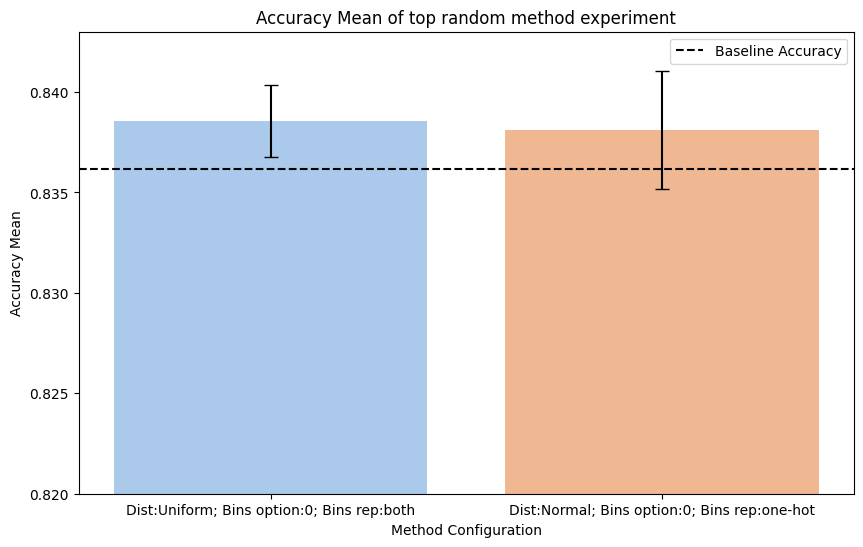

In [42]:
# Create the barplot
random_best_df = random_df.head(2).reset_index(drop=True)
plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=random_best_df, x='config_rt_sampling_distribution', y='mean', palette='pastel')

for i in range(len(random_best_df)):
    barplot.errorbar(i, random_best_df["mean"][i], yerr=random_best_df["std"][i], fmt='none', c='black', capsize=5)

plt.axhline(mean_baseline, linestyle='--', color='black', label='Baseline Accuracy')
# Add labels and title
plt.xlabel('Method Configuration')
new_xticks = ['Dist:Uniform; Bins option:0; Bins rep:both', 'Dist:Normal; Bins option:0; Bins rep:one-hot']
barplot.set_xticklabels(new_xticks)
plt.ylabel('Accuracy Mean')
plt.title('Accuracy Mean of top random method experiment')
plt.ylim(0.82, 0.843)
plt.legend()
plt.show()


/anaconda/envs/final_project_env/lib/python3.8/site-packages/seaborn/axisgrid.py:186: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self._figure.legend(handles, labels, **kwargs)


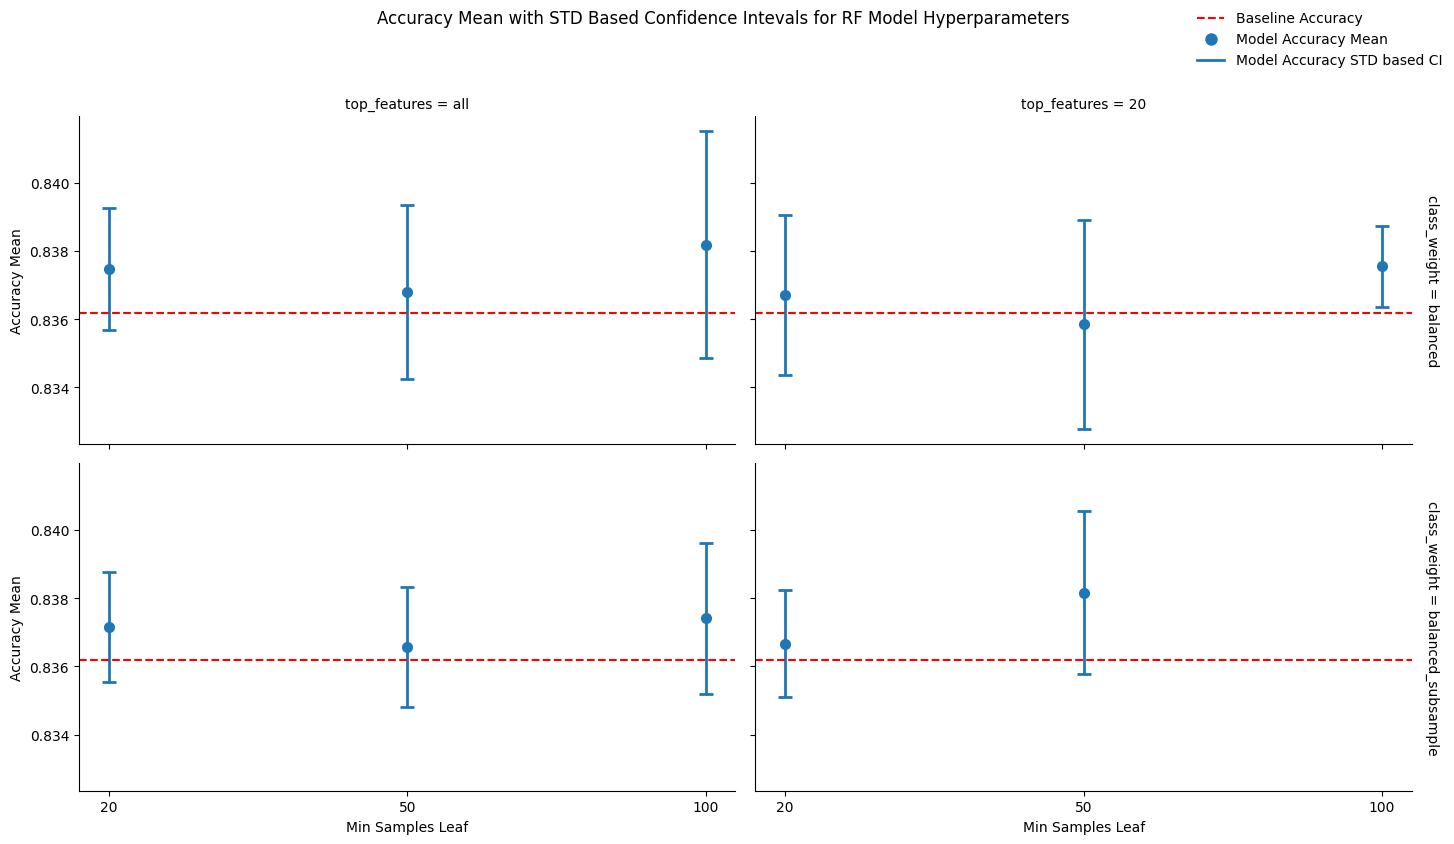

In [25]:
models_df = models_df.sort_values(by='config_rt_model_min_samples_leaf')
models_df['config_rt_model_min_samples_leaf'] = models_df['config_rt_model_min_samples_leaf'].astype('str')
models_df = models_df.rename(columns={"config_rt_model_class_weight": "class_weight", "config_rt_model_top_features": "top_features"})
g = sns.FacetGrid(models_df, col="top_features", row="class_weight", margin_titles=True, height=4, aspect=1.5)

def plot_with_baseline(data, **kwargs):
    plt.errorbar(data["config_rt_model_min_samples_leaf"], data["mean"], yerr=data["std"], fmt="o", capsize=5, elinewidth=2, markeredgewidth=2)
    plt.axhline(mean_baseline, linestyle='--', color='red', label='Baseline Accuracy')

g.map_dataframe(plot_with_baseline)
handles = [
    plt.Line2D([0], [0], color='red', linestyle='--', label='Baseline Accuracy'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='tab:blue', markersize=10, label='Model Accuracy Mean'),
    plt.Line2D([0], [0], color='tab:blue', linestyle='-', linewidth=2, label='Model Accuracy STD based CI')
]
g.add_legend(handles=handles, loc='upper right')
g.fig.suptitle('Accuracy Mean with STD Based Confidence Intevals for RF Model Hyperparameters', y=1.05)
g.set_axis_labels("Min Samples Leaf", "Accuracy Mean")
plt.tight_layout()
plt.show()

In [44]:
heuristic_df.sort_values("mean", ascending=False).head(3)

,config_input_dim,config_rt_baseline_std,config_rt_w_word_count,config_rt_bins_option_num,config_rt_bins_columns_rep,mean,std,values,epoch,CI,rt_neutral_sampling,rt_user_noise_std,rt_frustration_std_method
22,60,1000,300,0,one-hot,0.838573,0.001795,"[0.8392288967844506, 0.8391879777059144, 0.835...",13,"(0.837186058747428, 0.8398210436292161)",800,500,+
21,60,500,350,0,one-hot,0.838229,0.003230,"[0.8370609075093526, 0.8439230373015995, 0.835...",12,"(0.8363917222934031, 0.8411214560559681)",800,500,+
28,61,1000,300,0,both,0.838185,0.003556,"[0.832588945169034, 0.8383768877530517, 0.8379...",20,"(0.8355990124774889, 0.8409041209322371)",800,500,+


In [47]:
heuristic_df.sort_values("mean", ascending=False).head(3).to_csv('best_heuristics.csv')

In [45]:
best_random_df = random_df.sort_values(by="mean", ascending=False).iloc[[0]]
best_random_df['method'] = 'Random EDA'
best_random_df = best_random_df[['method', 'mean', 'std']]
best_heuristic_df = heuristic_df.sort_values(by="mean", ascending=False).iloc[[0]]
best_heuristic_df['method'] = 'Heuristic'
best_heuristic_df = best_heuristic_df[['method', 'mean', 'std']]
best_model_df = models_df.sort_values(by="mean", ascending=False).iloc[[0]]
best_model_df['method'] = 'RF Model'
best_model_df = best_model_df[['method', 'mean', 'std']]
baseline_res_df = baseline_df.copy()
baseline_res_df['method'] = "Shapira et al. Baseline"
baseline_res_df = baseline_res_df[['method', 'mean', 'std']]
best_res_df = pd.concat([baseline_res_df, best_random_df, best_model_df, best_heuristic_df]).reset_index(drop=True)
best_res_df

,method,mean,std
0,Shapira et al. Baseline,0.836190,0.001682
1,Random EDA,0.838557,0.001784
2,RF Model,0.838181,0.003327
3,Heuristic,0.838573,0.001795


/tmp/ipykernel_9112/2043718720.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=best_res_df, x='method', y='mean', palette=sns.color_palette("hls", 4))


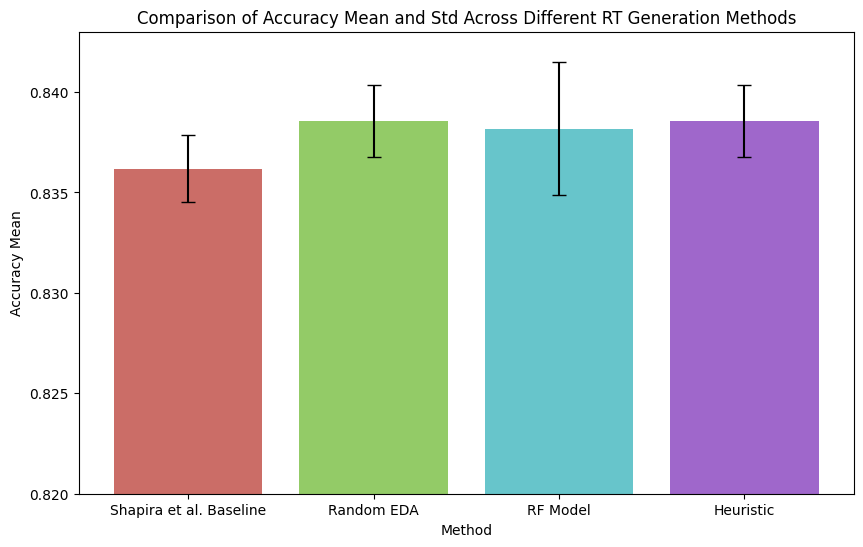

In [48]:
plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=best_res_df, x='method', y='mean', palette=sns.color_palette("hls", 4))

for i in range(len(best_res_df)):
    barplot.errorbar(i, best_res_df["mean"][i], yerr=best_res_df["std"][i], fmt='none', c='black', capsize=5)
# Add labels and title
plt.xlabel('Method')
plt.ylabel('Accuracy Mean')
plt.title('Comparison of Accuracy Mean and Std Across Different RT Generation Methods')
plt.ylim(0.82, 0.843)
plt.show()